# Examine raster inputs and corresponding outputs from boreal AGB modeling 
Use tindex csv and a focal tile number to grab correpsonding inputs and outputs

In [1]:
import rasterio as rio
import pandas as pd
import os
import s3fs
from rasterio.plot import show
import CovariateUtils_topo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
s3 = s3fs.S3FileSystem(anon=True)

### Examine bounds of tile inputs
Plot input and output COGs to show that the inputs 'look' good even for output AGB COGs that are inomplete  
Return a data frame  

In [9]:
s3 = s3fs.S3FileSystem(anon=True)
from shapely.geometry import box
import geopandas as gpd
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.style.use('seaborn-white')

def gdf_raster_bounds(FOCAL_TILE, ras_type, ras_bounds):
    
    gdf = gpd.GeoDataFrame({"tile_num": FOCAL_TILE, "raster_type": ras_type, "geometry":[box(*ras_bounds)]})
    return gdf

def DO_EXAMINE_TILE(FOCAL_TILE, 
    RASTER_INPUTS_LIST, RASTER_NAMES_LIST, 
    LOCAL_DOWNLOAD=False, SHOW_MAPS=True,
    #RASTER_NAMES_LIST =  ['land cover','HLS NBR2','elevation', 'AGB summer 2022', 'AGB fall 2022']
    #RASTER_INPUTS_LIST = [LC_tindex_master_fn, HLS_tindex_master_fn, Topo_tindex_master_fn, AGB_summer2022_tindex_master_fn, AGB_fall2022_noground_tindex_master_fn],
    CMAPS_LIST =         ['tab20', 'nipy_spectral', 'bone', 'viridis', 'viridis'],
    BANDNUM_LIST =       [1, 13, 1, 1, 1],
    
                    ):
    GDF_LIST = []
    DF_LIST = []
    RAS_BOUNDS_LIST = []
    
    # map raster names with colors
    ras_col_dic = {'land cover': 'Reds',
                   'HLS NBR2': 'Blues',
                   'elevation': 'Grays',
                   'AGB summer 2022': 'Greens',
                   'AGB fall 2022': 'Greens'
                  }
    
    n_plot_cols: int = len(RASTER_INPUTS_LIST)
    
    
    if SHOW_MAPS:
        print(f'Tile: {FOCAL_TILE}')
        fig, axes = plt.subplots(1, n_plot_cols, figsize=( n_plot_cols*4, 5))
        #divider = make_axes_locatable(axes)
    
    for i, f in enumerate(RASTER_INPUTS_LIST):
        
        z = pd.read_csv(f, storage_options={'anon':True})
        
        if len(z[z.tile_num == FOCAL_TILE]) > 0:
            cog_fn = z[z.tile_num == FOCAL_TILE].s3_path.to_list()[0]
            #print(os.path.basename(cog_fn))
            COG_EXISTS = True
        else:
            print(f'Tile {FOCAL_TILE} not in {f}')
            COG_EXISTS = False
            
            return None, None, None

        if LOCAL_DOWNLOAD:
            s3.download(cog_fn, '/projects/junk/' + os.path.basename(cog_fn))

        with rio.open(cog_fn, 'r') as ds:
            
            # Get bounds of raster
            ras_bounds = ds.bounds
            xmin, ymin, xmax, ymax = ras_bounds
            RAS_BOUNDS_LIST.append(ras_bounds)
            
            # Add gdf to list of gdfs
            GDF_LIST.append(gdf_raster_bounds(FOCAL_TILE, RASTER_NAMES_LIST[i], ras_bounds))
            
            # Read the data array
            arr = ds.read(BANDNUM_LIST[i])
            
            clims = (np.nanpercentile(arr, 10), np.nanpercentile(arr, 90))
            #show(ds)
            
            if 'elevation' in RASTER_NAMES_LIST[i]:
                #Replace elevation with its hillshade for display purposes
                arr = CovariateUtils_topo.hillshade(arr,315,45)
                clims = None
                
            if SHOW_MAPS:
                print(f'{os.path.basename(cog_fn)}:\t{ds.height} x {ds.width}\t{ras_bounds}')
                show(arr, ax=axes[i], cmap=CMAPS_LIST[i], clim=clims, title=f'Tile {FOCAL_TILE} {RASTER_NAMES_LIST[i]}')
            
    # 
    # Look at the max and the min of each bound of each image and find the max difference of each bound for each tile
    # 
    max_dif_bounds = [round(max(x[i] for x in RAS_BOUNDS_LIST) - min(x[i] for x in RAS_BOUNDS_LIST), 3) for i in range(0,4)]
    #print('Max difference in bounds of input: xmin, ymin, xmax, ymax:')    
    #print(max_dif_bounds)
    
    df = pd.DataFrame( [ {"tile_num": FOCAL_TILE,  "max_dif_xmin": max_dif_bounds[0], "max_dif_xmax": max_dif_bounds[1], "max_dif_ymin": max_dif_bounds[2], "max_dif_ymax": max_dif_bounds[3] } ] )
    #df = pd.DataFrame( [ {"tile_num": FOCAL_TILE,  "max_difs": max_dif_bounds} ] )
    #DF_LIST.append(df)
    
    # Make a GDF
    raster_input_bounds_footprint = pd.concat(GDF_LIST)
    #df_tile_max_difs_bounds = pd.concat(DF_LIST)
    
    return raster_input_bounds_footprint, RAS_BOUNDS_LIST, df #df_tile_max_difs_bounds


In [21]:
#AGB_summer2022_tindex_master_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.csv'  # <-- 07 indicates the summer update
#AGB_fall2022_tindex_master_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/AGB/fall2022/map_boreal_2022_v2/11/AGB_tindex_master.csv'
#AGB_fall2022_noground_tindex_master_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/AGB/fall2022/with_atl03_rh/map_boreal_2022_v4/12/AGB_tindex_master.csv'

AGB_localfull_H30_mosaic_json_fn = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/BOREAL_MAP/boreal_agb_2023_v3/AGB_H30_2020/local_training_full/AGB_tindex_master.csv'
AGB_localfull_L30_mosaic_json_fn = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/BOREAL_MAP/boreal_agb_2023_v3/AGB_L30_2020/local_training_full/AGB_tindex_master.csv'

LC_tindex_master_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/LC/LC_tindex_master.csv'
Topo_tindex_master_fn  = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv'
ATL08_filt_tindex_master_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/ATL08_filt_tindex_master.csv'

HLS_tindex_master_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master.csv'
### No - doesnt exist --- HLS_tindex_master_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2020/HLS_stack_2023_v1/HLS_tindex_master.csv'
HLS_tindex_master_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2020/HLS_stack_2022_v2/HLS_tindex_master.csv'

boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg' 

In [22]:
RASTER_INPUTS_LIST = [LC_tindex_master_fn, HLS_tindex_master_fn, Topo_tindex_master_fn, AGB_localfull_L30_mosaic_json_fn, AGB_localfull_H30_mosaic_json_fn]
RASTER_NAMES_LIST =  ['land cover','HLS NBR2','elevation', 'AGB from L30 c2020', 'AGB from H30 2020']

Tile: 1274
esa_worldcover_v100_2020_1274_cog.tif:	2999 x 3000	BoundingBox(left=5408521.781215043, bottom=5733319.030410317, right=5498536.819356105, top=5823304.063538666)
HLS_1274_06-15_09-01_2019_2021.tif:	3000 x 3000	BoundingBox(left=5408521.781215043, bottom=5733304.026653543, right=5498521.818100166, top=5823304.063538666)
Copernicus_1274_covars_cog_topo_stack.tif:	3000 x 3000	BoundingBox(left=5408522.0, bottom=5733304.0, right=5498522.0, top=5823304.0)
Tile 1274 not in s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/BOREAL_MAP/boreal_agb_2023_v3/AGB_L30_2020/local_training_full/AGB_tindex_master.csv
Tile: 1799
esa_worldcover_v100_2020_1799_cog.tif:	2999 x 2999	BoundingBox(left=5138522.154856866, bottom=4923304.051106027, right=5228522.140570063, top=5013304.036819224)
HLS_1799_06-15_09-01_2019_2021.tif:	3000 x 3000	BoundingBox(left=5138522.154856866, bottom=4923304.051106027, right=5228522.140570063, top=5013304.036819224)
Copernicus_1799_covars_cog_topo_stack.tif:	3000 

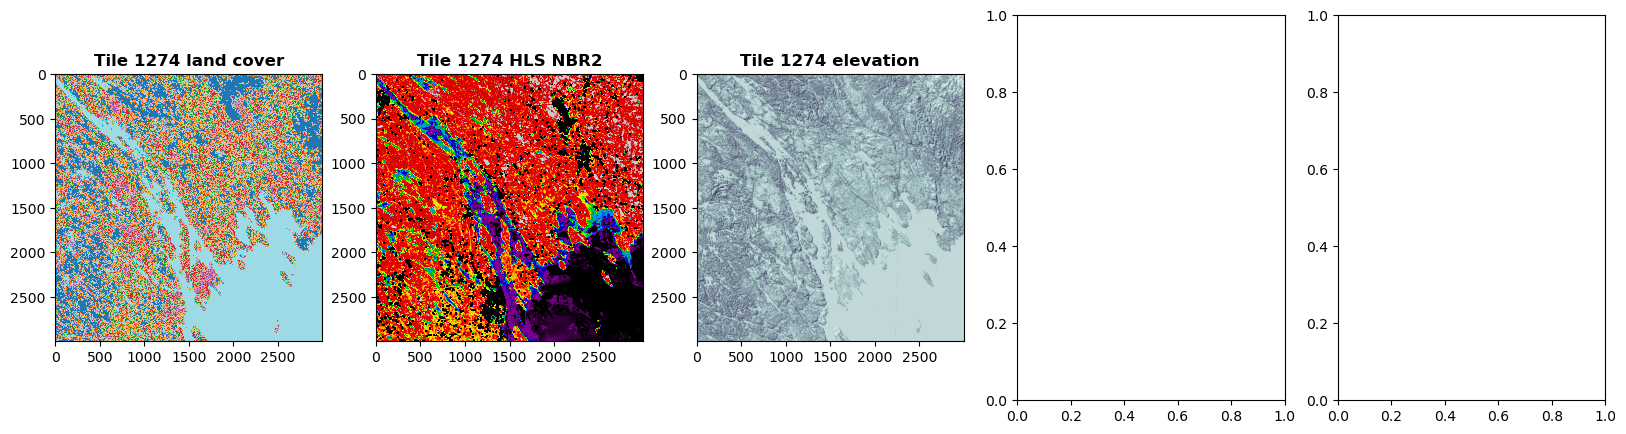

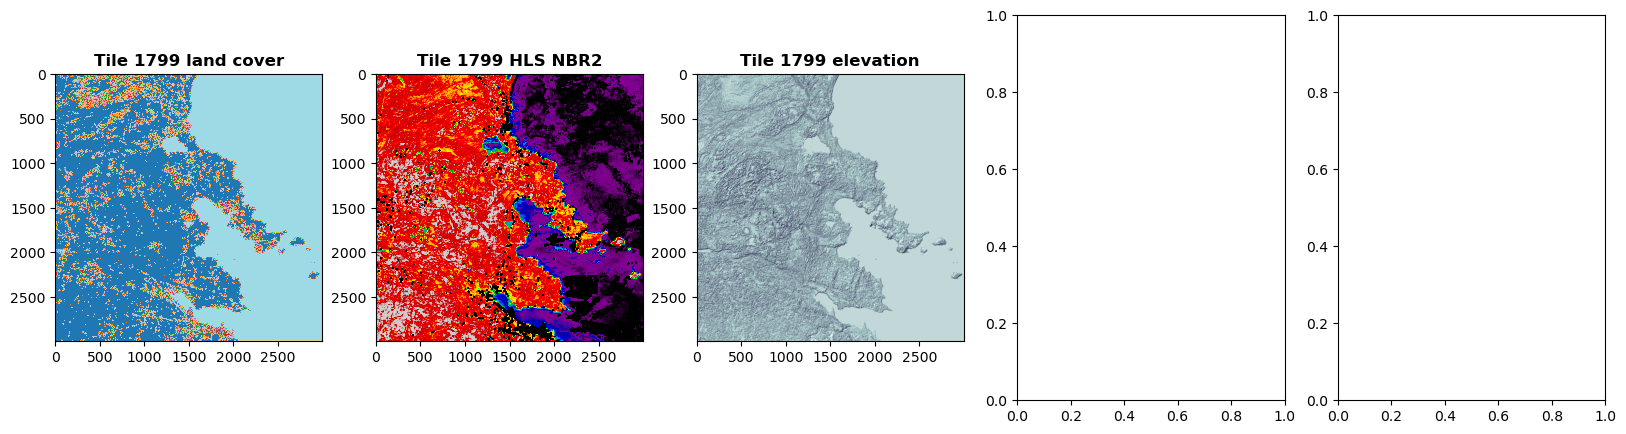

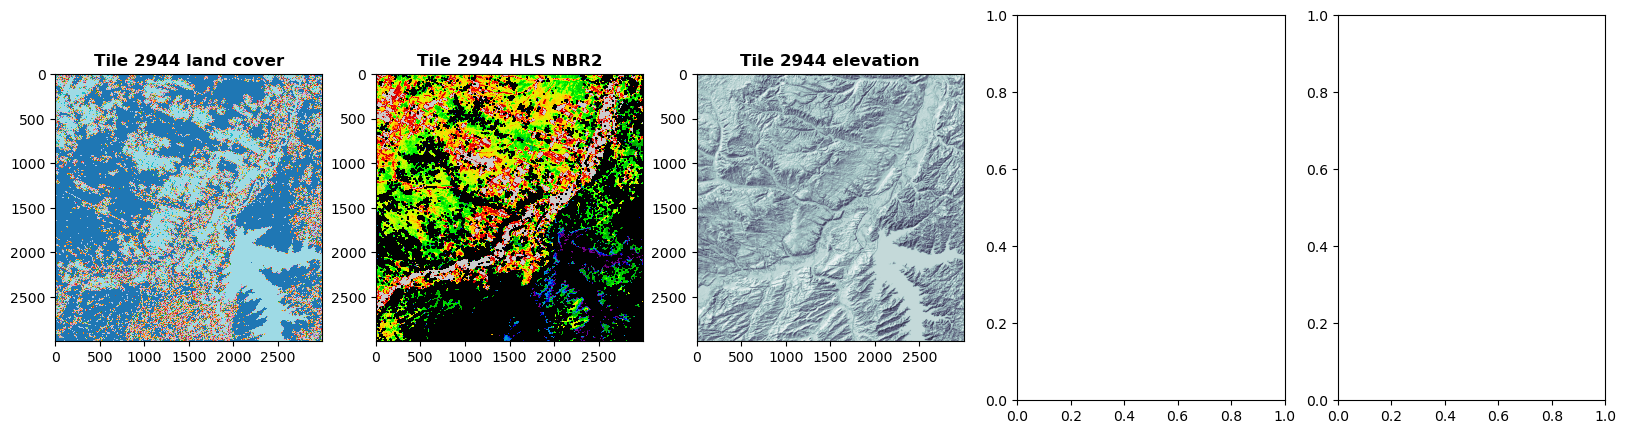

In [25]:
TILE_LIST_MESSED_UP = [1274, 1799, 2944] 

TILE_DF_LIST = []

for FOCAL_TILE in TILE_LIST_MESSED_UP:
    
    raster_input_bounds_footprint, bnds_list, df = DO_EXAMINE_TILE(FOCAL_TILE, RASTER_INPUTS_LIST, RASTER_NAMES_LIST, SHOW_MAPS=True)
    TILE_DF_LIST.append(df)

Tile: 3301
esa_worldcover_v100_2020_3301_cog.tif:	BoundingBox(left=4058521.772676861, bottom=3213319.0453903987, right=4148536.7401175564, top=3303304.0078419475)
HLS_3301_06-15_09-01_2019_2021.tif:	BoundingBox(left=4058521.772676861, bottom=3213319.0453903987, right=4148536.7401175564, top=3303304.0078419475)
Copernicus_3301_covars_cog_topo_stack.tif:	BoundingBox(left=4058522.0, bottom=3213304.0, right=4148522.0, top=3303304.0)
boreal_agb_202207041656965977_3301.tif:	BoundingBox(left=4058522.0, bottom=3213304.0, right=4148522.0, top=3303304.0)
boreal_agb_202212051670213860_3301.tif:	BoundingBox(left=4058522.0, bottom=3213304.0, right=4148522.0, top=3303304.0)
Tile: 3302
esa_worldcover_v100_2020_3302_cog.tif:	BoundingBox(left=4148521.8581597432, bottom=3213319.0634677806, right=4238536.924685612, top=3303304.1249714745)
HLS_3302_06-01_09-15_2019_2021.tif:	BoundingBox(left=4148521.8581597432, bottom=3213319.0634677806, right=4238536.924685612, top=3303304.1249714745)
Copernicus_3302_cov

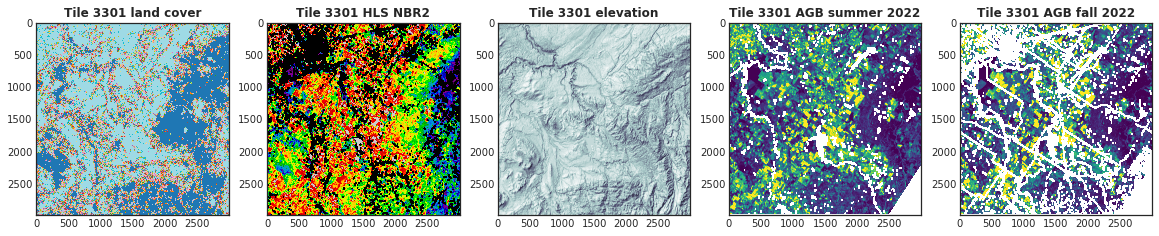

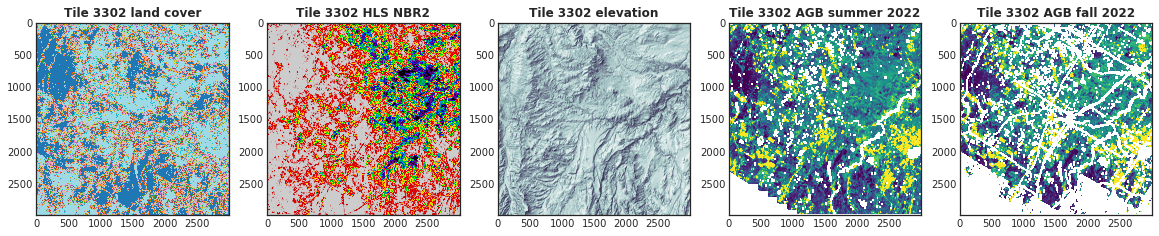

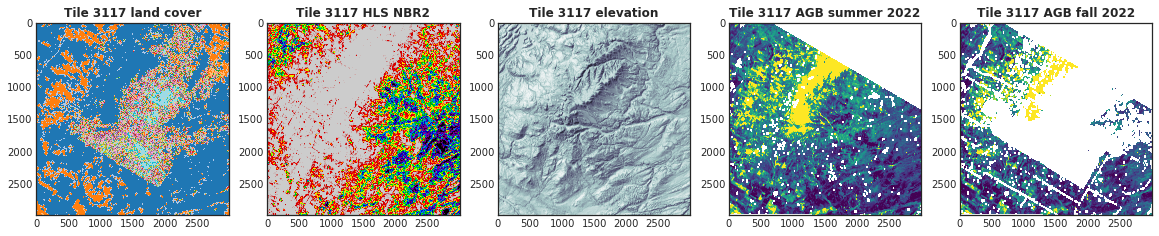

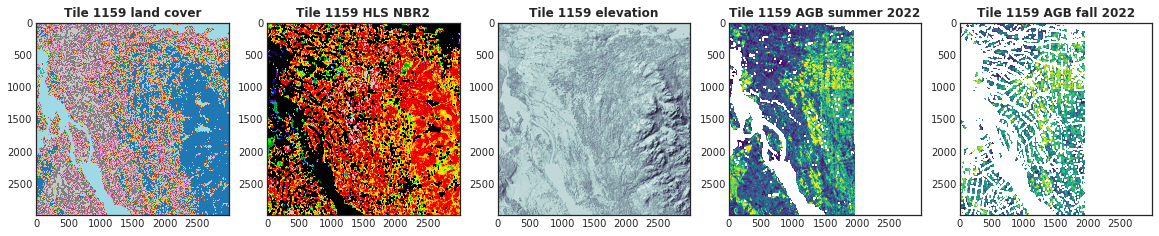

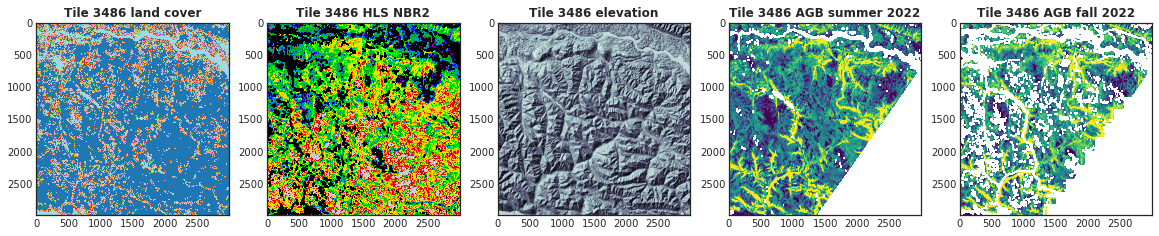

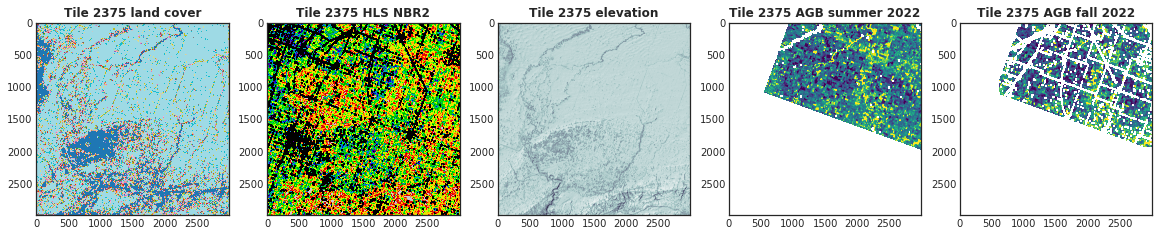

In [184]:
%matplotlib inline

TILE_LIST_MESSED_UP = [3301, 3302, 3117, 1159, 3486, 2375] #1105, 
#TILE_LIST_MESSED_UP = [3301, 3302]
TILE_DF_LIST = []

for FOCAL_TILE in TILE_LIST_MESSED_UP:
    
    raster_input_bounds_footprint, bnds_list, df = DO_EXAMINE_TILE(FOCAL_TILE, SHOW_MAPS=True)
    TILE_DF_LIST.append(df)

df_tile_max_difs_bounds = pd.concat(TILE_DF_LIST)

#### Printing out the max bounds from these tiles shows that there is a half a pixel (~15 m) different in the bounds of the inputs

In [185]:
df_tile_max_difs_bounds

tile_num  max_dif_xmin  max_dif_xmax  max_dif_ymin  max_dif_ymax
0      3301         0.227        15.045        14.740         0.008
0      3302         0.142        15.063        14.925         0.125
0      3117         0.000        14.995        15.215         0.206
0      1159         0.000        14.919        15.058         0.028
0      3486         0.004        14.730        15.049         0.230
0      2375         0.000        14.947        15.061         0.003

Tile: 1448
esa_worldcover_v100_2020_1448_cog.tif:		BoundingBox(left=5318521.999999994, bottom=5463289.034167586, right=5408506.960843807, top=5553304.000000009)
HLS_1448_06-15_09-01_2019_2021.tif:		BoundingBox(left=5318521.999999994, bottom=5463289.034167586, right=5408506.960843807, top=5553304.000000009)
Copernicus_1448_covars_cog_topo_stack.tif:		BoundingBox(left=5318522.0, bottom=5463304.0, right=5408522.0, top=5553304.0)
boreal_agb_202207041656950222_1448.tif:		BoundingBox(left=5318522.0, bottom=5463304.0, right=5408522.0, top=5553304.0)
boreal_agb_202212051670217781_1448.tif:		BoundingBox(left=5318522.0, bottom=5463304.0, right=5408522.0, top=5553304.0)
Tile: 1449
esa_worldcover_v100_2020_1449_cog.tif:		BoundingBox(left=5408521.893644242, bottom=5463318.991273854, right=5498536.926486208, top=5553304.019104874)
HLS_1449_06-15_09-01_2019_2021.tif:		BoundingBox(left=5408521.893644242, bottom=5463318.991273854, right=5498536.926486208, top=5553304.019104874)
Copernicus_1449_covars_c

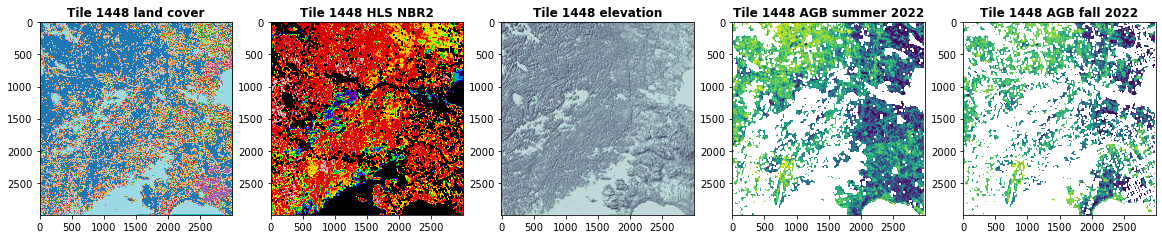

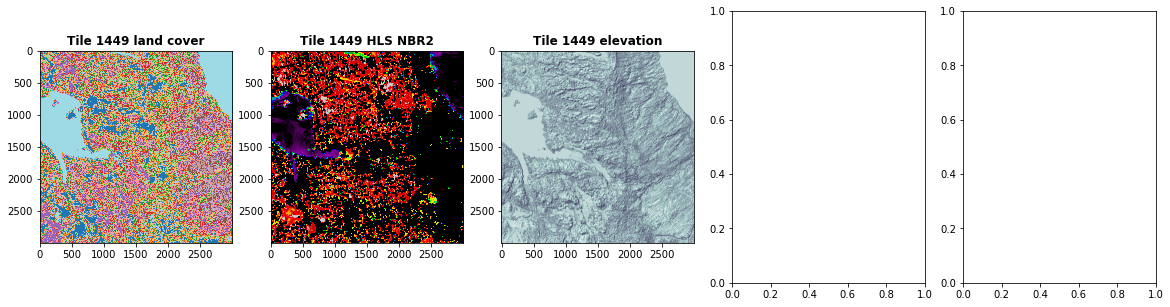

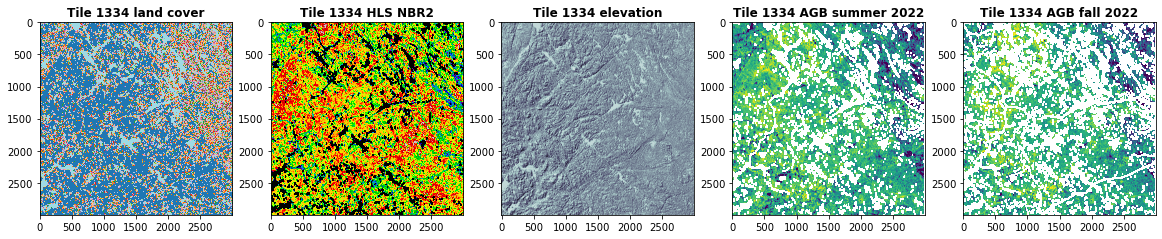

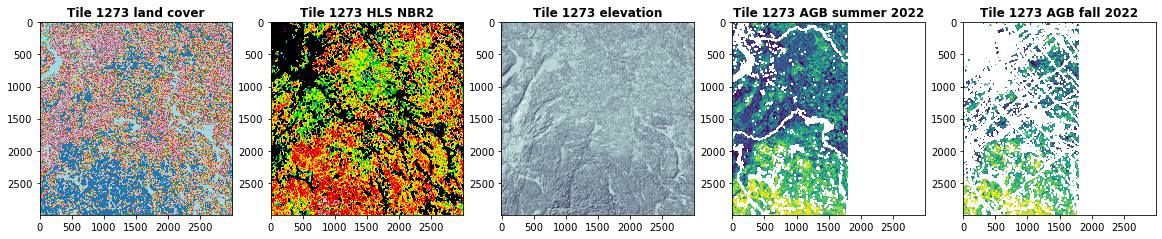

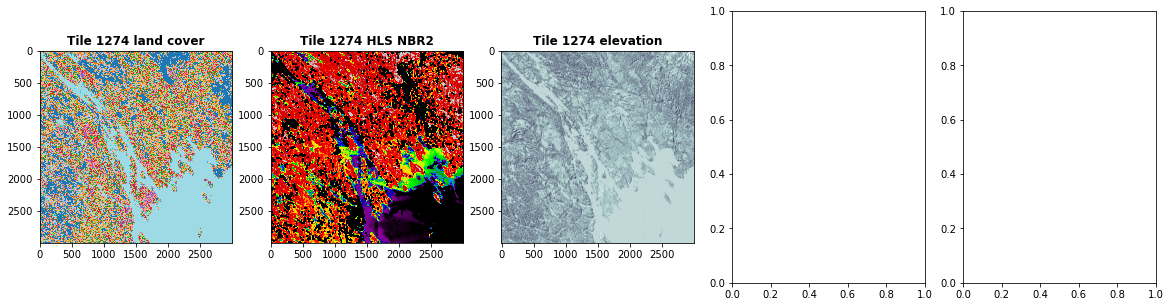

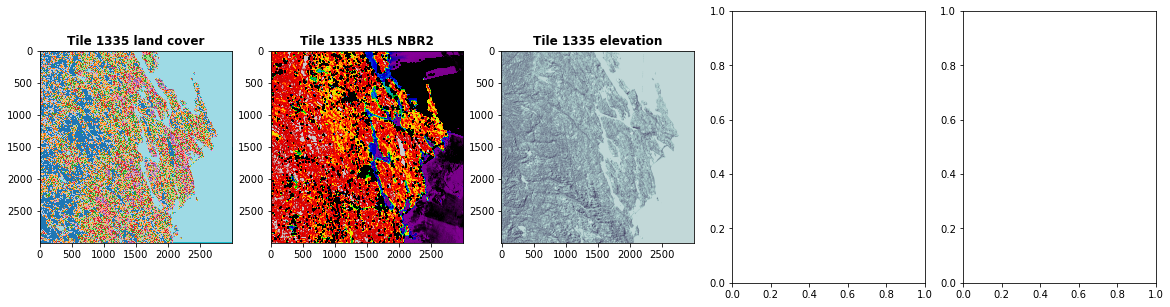

In [5]:
TILE_LIST_MESSED_UP_southCA = [1448, 1449, 1334, 1273, 1274, 1335]  
#TILE_LIST_MESSED_UP = [3301, 3302]
TILE_DF_LIST_southCA = []

for FOCAL_TILE in TILE_LIST_MESSED_UP_southCA:
    
    raster_input_bounds_footprint, bnds_list, df = DO_EXAMINE_TILE(FOCAL_TILE, SHOW_MAPS=True)
    TILE_DF_LIST_southCA.append(df)

df_tile_max_difs_bounds_southCA = pd.concat(TILE_DF_LIST_southCA)

In [6]:
df_tile_max_difs_bounds_southCA

tile_num  max_dif_xmin  max_dif_xmax  max_dif_ymin  max_dif_ymax
0      1448           0.0        14.966        15.039         0.000
0      1334           0.0        14.872        15.014         0.119
0      1273           0.0        14.930        15.075         0.000

#### Most tiles do not have this problem
here are some a couple eaxmple tiles that are fine

Tile: 3457
esa_worldcover_v100_2020_3457_cog.tif:	BoundingBox(left=1358521.9999999953, bottom=3033304.0000000093, right=1448521.9999999953, top=3123304.0000000093)
HLS_3457_06-01_09-15_2019_2021.tif:	BoundingBox(left=1358521.9999999953, bottom=3033304.0000000093, right=1448521.9999999953, top=3123304.0000000093)
Copernicus_3457_covars_cog_topo_stack.tif:	BoundingBox(left=1358522.0, bottom=3033304.0, right=1448522.0, top=3123304.0)
boreal_agb_202207041656944772_3457.tif:	BoundingBox(left=1358522.0, bottom=3033304.0, right=1448522.0, top=3123304.0)
boreal_agb_202212051670214339_3457.tif:	BoundingBox(left=1358522.0, bottom=3033304.0, right=1448522.0, top=3123304.0)
Tile: 164
esa_worldcover_v100_2020_164_cog.tif:	BoundingBox(left=-2961478.0000000047, bottom=8163304.000000009, right=-2871478.0000000047, top=8253304.000000009)
HLS_164_06-01_09-15_2019_2021.tif:	BoundingBox(left=-2961478.0000000047, bottom=8163304.000000009, right=-2871478.0000000047, top=8253304.000000009)
Copernicus_164_cov

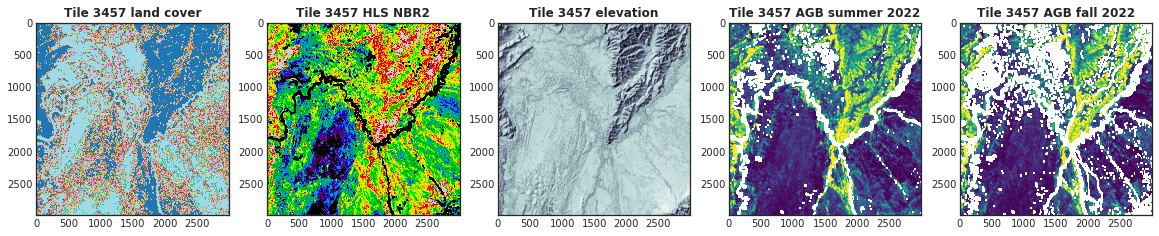

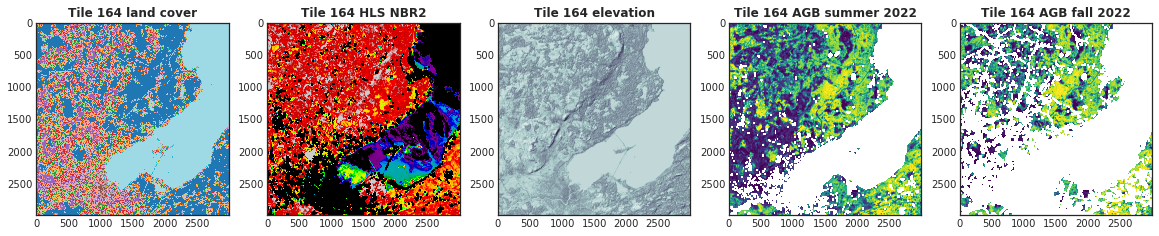

In [189]:
TILE_LIST_FINE = [3457, 164]
TILE_DF_LIST_FINE = []

for FOCAL_TILE in TILE_LIST_FINE:
    
    raster_input_bounds_footprint, bnds_list, df = DO_EXAMINE_TILE(FOCAL_TILE, SHOW_MAPS=True)
    TILE_DF_LIST_FINE.append(df)

df_tile_max_difs_bounds = pd.concat(TILE_DF_LIST_FINE)

In [191]:
df_tile_max_difs_bounds

tile_num  max_dif_xmin  max_dif_xmax  max_dif_ymin  max_dif_ymax
0      3457           0.0           0.0           0.0           0.0
0       164           0.0           0.0           0.0           0.0

## Find all problem tiles from MODEL READY TILES
Now go through all tiles and build a data frame with the max bound difs to map all tiles and show where problem tiles are

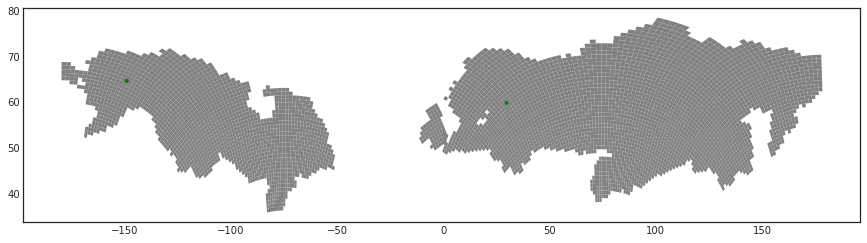

In [198]:
# Get all boreal tiles
boreal_tile_index = gpd.read_file(boreal_tile_index_path)

# Actually - we should just find problem tiles using the AGB tindex: AGB_fall2022_noground_tindex_master_fn

model_ready_tiles_df = pd.read_csv('/projects/shared-buckets/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/model_ready_tiles.csv')
model_ready_tile_index = boreal_tile_index.merge(model_ready_tiles_df, how='right', on='tile_num')
tiles_fine = model_ready_tile_index[model_ready_tile_index['tile_num'].isin(df_tile_max_difs_bounds.tile_num.to_list())]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax = model_ready_tile_index.to_crs(4326).plot(ax=ax, color='grey')
tiles_fine.to_crs(4326).plot(ax=ax, color='green')

In [201]:
MODEL_READY_TILES_LIST = model_ready_tile_index.tile_num.to_list()
len(MODEL_READY_TILES_LIST)

CPU times: user 268 µs, sys: 40 µs, total: 308 µs
Wall time: 317 µs


5185

#### Run across all model ready tiles to get a df of max bounds difs

In [ ]:
%%time

MODEL_READY_TILES_DF_LIST = []

for FOCAL_TILE in MODEL_READY_TILES_LIST:
    
    raster_input_bounds_footprint, bnds_list, df = DO_EXAMINE_TILE(FOCAL_TILE, SHOW_MAPS=False)
    MODEL_READY_TILES_DF_LIST.append(df)

df_MODEL_READY_TILES_DF_max_difs_bounds = pd.concat(MODEL_READY_TILES_DF_LIST)

Tile 996 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.csv
Tile 2084 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.csv
Tile 37527 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.csv
Tile 107 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.csv
Tile 3868 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.csv
Tile 997 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.csv
Tile 37303 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.csv
Tile 3402 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.csv
Tile 2745 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.csv
Tile 1738 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB

/projects/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


Tile 1050 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/AGB/fall2022/with_atl03_rh/map_boreal_2022_v4/12/AGB_tindex_master.csv
Tile 36023 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.csv
Tile 1316 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/AGB/fall2022/with_atl03_rh/map_boreal_2022_v4/12/AGB_tindex_master.csv
Tile 36246 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.csv
Tile 36250 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.csv
Tile 1282 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.csv
Tile 36921 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.csv
Tile 36475 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_tindex_master.csv
Tile 35352 not in s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/07/AGB_ti

#### Join with boreal tindex and map max bounds difs

In [1]:
df_MODEL_READY_TILES_DF_max_difs_bounds

NameError: name 'df_MODEL_READY_TILES_DF_max_difs_bounds' is not defined

In [202]:
if False:
    
    ras_col_dic = {'land cover': 'Red',
               'HLS NBR2': 'Blue',
               'elevation': 'Grey',
              'AGB summer 2022': 'Green',
              'AGB fall 2022': 'Purple'}

    fig, ax = plt.subplots(1, 1, figsize=( 3, 5))

    for ras_name, color in ras_col_dic.items():
        ax = raster_input_bounds_footprint.plot(ax=ax, column='raster_type', alpha = 0.01, color=color)